In [ ]:
# default_exp datasets.loaders

# Dataset loaders

Methods for downloading the manga covers from the MangaDex database.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
import requests
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from tqdm.auto import tqdm
from mangacover.datasets.internals.MangaDex import get_covers_for_all_tags

def create_multiclass_tag_manga_dataset(path, num_mangas=20):
    """Saves a dataset for the multiclassification problem of deriving the tags associated with
    a manga by its cover, in `path`.
    """
    print('Fetching manga metadata from the MangaDex API...')
    manga_df = get_covers_for_all_tags(num_mangas)
    folder = Path(f'{path}')
    folder.mkdir(parents=True, exist_ok=True)
    print(f'Saving data to {folder}...')
    for manga in tqdm(list(manga_df.itertuples())):
        my_file = folder/manga.filename
        if my_file.exists():
            manga_df.at[manga.Index, 'failed'] = False
            continue
        try:
            im = Image.open(requests.get(manga.url, stream=True).raw)
            im.save(folder/manga.filename)
            manga_df.at[manga.Index, 'failed'] = False
        except UnidentifiedImageError:
            print("Warning: Couldn't identify image file " + manga.filename + ". Skipping.")
            manga_df.at[manga.Index, 'failed'] = True
    metadata_csv_path = folder/'dataset.csv'
    print(f'Writing metadata csv file at {metadata_csv_path}')
    manga_df.to_csv(metadata_csv_path)
    print('Done.')

In [ ]:
show_doc(create_multiclass_tag_manga_dataset)

<h4 id="create_multiclass_tag_manga_dataset" class="doc_header"><code>create_multiclass_tag_manga_dataset</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>create_multiclass_tag_manga_dataset</code>(**`path`**, **`num_mangas`**=*`20`*)

Saves a dataset for the multiclassification problem of deriving the tags associated with
a manga by its cover, in `path`.

Let's create the dataset in the `data/` folder

In [ ]:
create_multiclass_tag_manga_dataset('data/')

Fetching manga metadata from the MangaDex API...


  0%|          | 0/76 [00:00<?, ?it/s]

Saving data to data...


  0%|          | 0/833 [00:00<?, ?it/s]

Writing metadata csv file at data/dataset.csv
Done.


Here's how the metadata csv file looks like. We can use the `filename` to load the files and the `tags` are pipe (|) separated, so we need to handle those to pass to our model.

In [ ]:
import pandas as pd

mangas_df = pd.read_csv('data/dataset.csv')
mangas_df.head()

,Unnamed: 0,mangaId,url,filename,tags,failed
0,0,2661ccb2-9b4e-42bb-9697-bed499b9b363,https://uploads.mangadex.org/covers/2661ccb2-9b4e-42bb-9697-bed499b9b363/be17ccee-d9dc-40e1-bca4-0cf464dd632d.jpg,2661ccb2-9b4e-42bb-9697-bed499b9b363_be17ccee-d9dc-40e1-bca4-0cf464dd632d.jpg,Oneshot|Reincarnation|Historical|Romance|Anthology|Video Games|Sexual Violence|Magic|Isekai|Drama|Fantasy|Villainess|Adaptation,False
1,1,cb34b520-fd48-474e-8d06-a7a25473342e,https://uploads.mangadex.org/covers/cb34b520-fd48-474e-8d06-a7a25473342e/5035057d-19e0-4950-a230-68d0caf0c7a9.jpg,cb34b520-fd48-474e-8d06-a7a25473342e_5035057d-19e0-4950-a230-68d0caf0c7a9.jpg,Oneshot|Romance|Comedy|Slice of Life,False
2,2,ab468776-27a5-456d-8f58-e058059531c9,https://uploads.mangadex.org/covers/ab468776-27a5-456d-8f58-e058059531c9/4a18ccf6-3038-4fcb-a44d-598d1c4bc7b3.jpg,ab468776-27a5-456d-8f58-e058059531c9_4a18ccf6-3038-4fcb-a44d-598d1c4bc7b3.jpg,Oneshot|Romance|Comedy|Anthology|Office Workers|Drama|School Life|Slice of Life,False
3,3,11afa5c2-41dc-4cf3-8451-f306a3caf1ab,https://uploads.mangadex.org/covers/11afa5c2-41dc-4cf3-8451-f306a3caf1ab/31616f14-95a8-41e5-bf42-0292087c4158.jpg,11afa5c2-41dc-4cf3-8451-f306a3caf1ab_31616f14-95a8-41e5-bf42-0292087c4158.jpg,Oneshot|Romance|Comedy|Anthology|Office Workers|Drama|School Life|Slice of Life,False
4,4,cd8197af-e771-46de-82a0-5e70f977e6a1,https://uploads.mangadex.org/covers/cd8197af-e771-46de-82a0-5e70f977e6a1/a5a3b64c-4c92-40a4-938c-f04979161c47.jpg,cd8197af-e771-46de-82a0-5e70f977e6a1_a5a3b64c-4c92-40a4-938c-f04979161c47.jpg,Oneshot|Romance|Comedy|Anthology|School Life,False


In [ ]:
# export
from fastai.vision.all import *
import pandas as pd

def _get_mangacover_x(path, r): return path/r['filename']
def _get_mangacover_y(r): return r['tags'].split('|')

def get_mangacover_dataloaders(path):
    """Creates dataloaders based on the dataset in `path`"""
    folder = Path(f'{path}')
    mangas_df = pd.read_csv(folder/'dataset.csv')

    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                       get_y=_get_mangacover_y, get_x=partial(_get_mangacover_x, folder),
                       item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))

    return dblock.dataloaders(mangas_df)

In [ ]:
show_doc(get_mangacover_dataloaders)

<h4 id="get_mangacover_dataloaders" class="doc_header"><code>get_mangacover_dataloaders</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>get_mangacover_dataloaders</code>(**`path`**)

Creates dataloaders based on the dataset in `path`

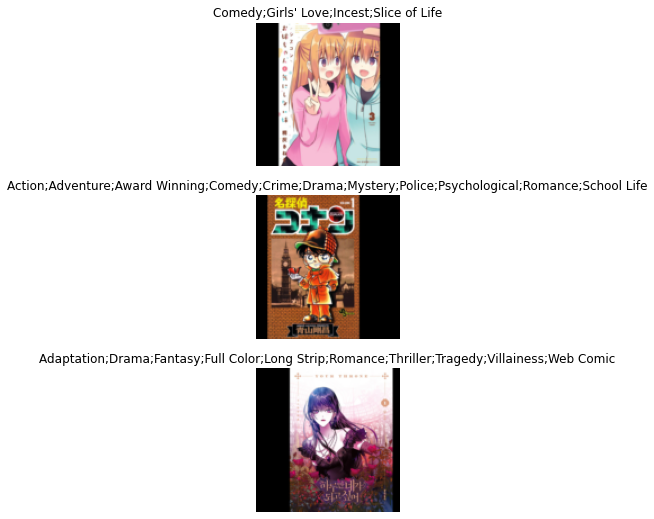

In [ ]:
dls = get_mangacover_dataloaders('data/')
dls.show_batch(nrows=3, ncols=1)